# 3D Symmetric Stage
Symmetric stage could be useful if the inlet becomes and outlet and vice versa. This is a bit confusing, what scenario would that occur? Well a shocktube where there's a pressure wave that's reflected.

Example where a symmetric turbine stage could be useful in extracting power.
Inlet (P0, T0) | Stator | Rotor | Stator | Outlet (P_static)

Outlet (P_static) | Stator | Rotor | Stator | Inlet (P0)

This example shows how to build such a geometry.

In [2]:
!pip install pyturbo-aero

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.0/148.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 3.0 MB/s eta 0:00:00


In [3]:
import numpy as np
from pyturbo.helper import bezier
rtip = 50/1000 # Constraint: max 50mm
rhub = 42/1000 # Variable
blade_height = rtip - rhub
aspect_ratios = [0.95, 1, 0.95] # height / chord for stator,rotor,stator
blade_chords = blade_height * np.array(aspect_ratios)

max_chord = max(blade_chords)
x = [-max_chord,max_chord,3.5*max_chord] # inlet, stator, spacing + rotor + more spacing
r_tip = [rtip, rtip, rtip]
r_hub = [rhub, rhub, rhub]

bezier_tip = bezier(x,r_tip)
bezier_hub = bezier(x,r_hub)
tip_points = np.array(bezier_tip.get_point(np.linspace(0,1,100))).transpose()
hub_points = np.array(bezier_hub.get_point(np.linspace(0,1,100))).transpose()

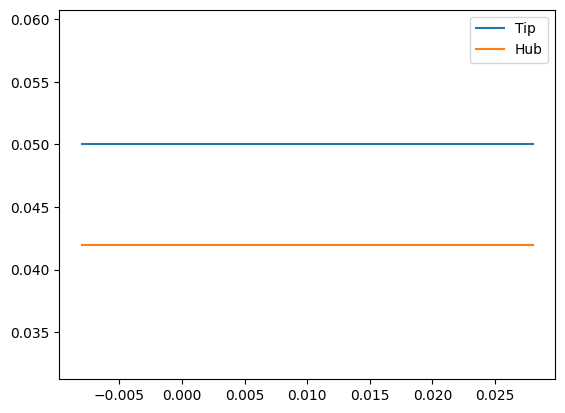

In [4]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(tip_points[:,0],tip_points[:,1],label='Tip')
plt.plot(hub_points[:,0],hub_points[:,1],label='Hub')
plt.legend()
plt.axis('equal')
plt.show()

## Stator Design
Design stator then flip it

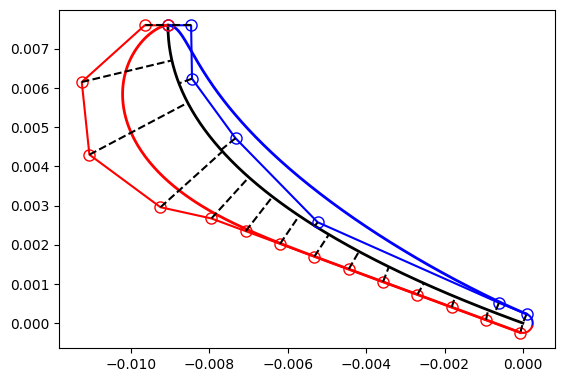

In [5]:
from pyturbo.aero import Airfoil2D, Airfoil3D
from pyturbo.helper import StackType

# Stator
stator_hub = Airfoil2D(alpha1=0,alpha2=70,axial_chord=blade_chords[0],stagger=50)
# stator_hub.plot_camber()
stator_hub.add_le_thickness(0.05)
ps_height = [ 0.03,0.04,0.01]
stator_hub.add_ps_thickness(thicknessArray=ps_height,expansion_ratio=1.2,camberPercent=0.95)
ss_height = [ 0.2,0.24,0.18,0.14]
stator_hub.add_ss_thickness(thicknessArray=ss_height,expansion_ratio=1.2,camberPercent=0.8)
stator_hub.match_thickness(location='LE')
stator_hub.te_create(0.00025,5,2)
stator_hub.add_ss_flow_guidance_2(0.8,10) # Useful for highspeed flows

stator_tip = Airfoil2D(alpha1=0,alpha2=70,axial_chord=blade_chords[0],stagger=50)
stator_tip.add_le_thickness(0.05)
ps_height = [ 0.03,0.04,0.01]
stator_tip.add_ps_thickness(thicknessArray=ps_height,expansion_ratio=1.2,camberPercent=0.95)
ss_height = [ 0.2,0.24,0.18,0.14]
stator_tip.add_ss_thickness(thicknessArray=ss_height,expansion_ratio=1.2,camberPercent=0.8)
stator_tip.match_thickness(location='LE')
stator_tip.te_create(0.00025,5,2)
stator_tip.add_ss_flow_guidance_2(0.8,10) # Useful for highspeed flows
stator_tip.plot2D()

/usr/local/lib/python3.11/dist-packages/pyturbo/helper/bezier.py:365: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  temp = minimize_scalar(f2,bounds=(t_start,t_end),method="bounded",tol=1e-6,args=(t_start))
Equal Spacing suction and pressure side: 100%|██████████| 20/20 [00:00<00:00, 287.52it/s]


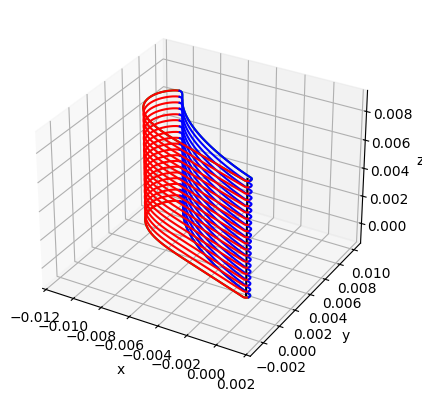

In [6]:
stator3D = Airfoil3D([stator_hub,stator_tip],[0,1],rtip-rhub)
stator3D.stack(StackType.leading_edge)
# stator3D.add_sweep(sweep_y=[0,-0.05,0.01], sweep_z=[0.0, 0.5, 1]) # Z =1 is blade tip, Z = 0 is blade hub. The units are in percentage
# stator3D.add_lean(leanX=[0,0.1,0.05], leanZ=[0,0.5,1])
stator3D.build(nProfiles=20,num_points=160,trailing_edge_points=20)
stator3D.plot3D()

## Rotor Design
Symmetric Rotor Design

check


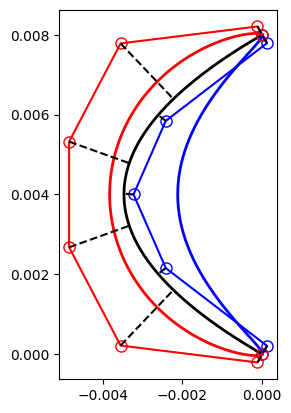

In [7]:
### Hub Profile
rotor_axial_chord = blade_chords[1]
rotor_hub = Airfoil2D(alpha1=60,alpha2=60,axial_chord=rotor_axial_chord,stagger=0) # This creates the camberline
rotor_hub.add_le_thickness(0.03)
# Building the Pressure side
ps_height = [0.0300,0.0300,0.0300] # These are thicknesses
rotor_hub.add_ps_thickness(thicknessArray=ps_height,expansion_ratio=1.0,camberPercent=1)
ss_height=[0.2400, 0.2000, 0.200, 0.2400]
rotor_hub.add_ss_thickness(thicknessArray=ss_height,expansion_ratio=1.0,camberPercent=1.0)

rotor_hub.match_thickness(location='LE')
rotor_hub.te_create_reversible(0.03)
rotor_hub.match_thickness(location='TE')
rotor_hub.plot2D()

In [8]:
rotor_mid = Airfoil2D(alpha1=58,alpha2=58,axial_chord=rotor_axial_chord*0.98,stagger=0) # This creates the camberline
# rotor_mid.plot_camber()

# Building Leading Edge
rotor_mid.add_le_thickness(0.03)
# Building the Pressure side
ps_height = [0.0500,0.0500,0.0500] # These are thicknesses
rotor_mid.add_ps_thickness(thicknessArray=ps_height,expansion_ratio=1.0,camberPercent=1)
ss_height=[0.2400, 0.2000, 0.200, 0.2400]
rotor_mid.add_ss_thickness(thicknessArray=ss_height,expansion_ratio=1.0,camberPercent=1.0)
# stator_hub.match_le_thickness()
rotor_mid.match_thickness(location='LE')
rotor_mid.te_create_reversible(0.03)
rotor_mid.match_thickness(location='TE')
# rotor_mid.plot2D()

check


In [9]:
rotor_tip = Airfoil2D(alpha1=55,alpha2=55,axial_chord=rotor_axial_chord*0.96,stagger=0) # This creates the camberline
# rotor_tip.plot_camber()

# Building Leading Edge
rotor_tip.add_le_thickness(0.03)
# Building the Pressure side
ps_height = [0.0500,0.0500,0.0500] # These are thicknesses
rotor_tip.add_ps_thickness(thicknessArray=ps_height,expansion_ratio=1.0,camberPercent=1)
ss_height=[0.2400, 0.2000, 0.200, 0.2400]
rotor_tip.add_ss_thickness(thicknessArray=ss_height,expansion_ratio=1.0,camberPercent=1.0)
# stator_hub.match_le_thickness()
rotor_tip.match_thickness(location='LE')
rotor_tip.te_create_reversible(0.03)
rotor_tip.match_thickness(location='TE')
# rotor_tip.plot2D()

check


Equal Spacing suction and pressure side: 100%|██████████| 20/20 [00:00<00:00, 191.88it/s]


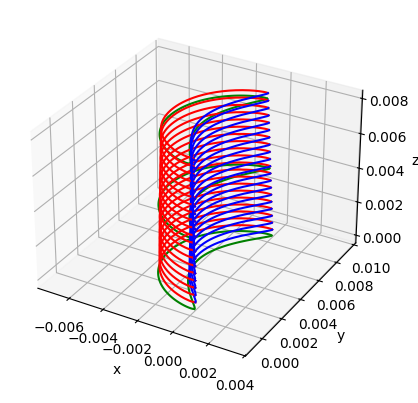

In [10]:
#%% Rotor 3D
rotor3D = Airfoil3D(profileArray=[rotor_hub,rotor_mid,rotor_tip],profile_loc=[0.0,0.5,1.0], height = rtip-rhub)
rotor3D.stack(StackType.centroid)
rotor3D.build(nProfiles=20,num_points=120,trailing_edge_points=20)
rotor3D.plot3D()

## Add the Airfoils into the passage and flip the stator    

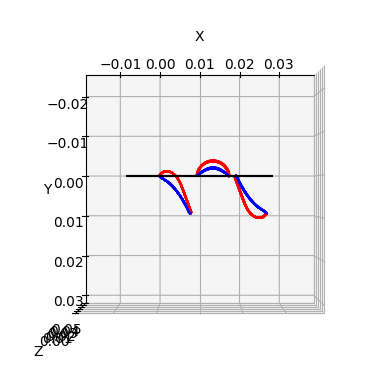

In [11]:
# Passage
from pyturbo.aero import Passage2D
import copy
stator2_3D = copy.deepcopy(stator3D)

stator3D.rotate(0,0,90)
rotor3D.rotate(0,0,90)
stator2_3D.rotate(0,0,90)


passage = Passage2D([stator3D,rotor3D,stator2_3D],[max_chord*0.2,max_chord*0.2])
passage.add_endwalls(hub_points[:,0],hub_points[:,1],tip_points[:,0],tip_points[:,1])
passage.blade_fit(0)
# Reorder points for last airfoil so that trailing edge is first
passage.airfoils[-1].flip_le_te()
passage.plot3D()
